# Geostrophic Balance

Here we study the surface currents modeled by the 2D incompressible Navier-Stokes equations on a rotating sphere:

$$ u_{t} + (\mathbf{u} \cdot \nabla)u + fv = -\frac{1}{\rho} p_{x} $$
$$ v_{t} + (\mathbf{u} \cdot \nabla)v - fu = -\frac{1}{\rho} p_{y} $$

where $\rho$ is the density, x and y are the zonal and meridional coordinates respectively. $f$, the Coriolis parameter is given in terms of the Earth's rotation rate $\Omega$ and the latitude $\phi$.

For this case study, the data is obtainable from this [URL](https://data.hycom.org/datasets/GOMu0.04/expt_50.1/data/netcdf/1993/) directly. The fields used are the first and second fields of the hindcasts (see below).

This code was written based on the paper and the supplementary information provided.

In [827]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import sklearn as sk

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf

## 1. Load the data


In [828]:
# Read in the data from the nc files at 2 times to get time derivatives
path1 = "../Data/hycom_gomu_501_1993010100_t000.nc"
path2 = "../Data/hycom_gomu_501_1993010100_t003.nc"
data_t1 = xr.open_dataset(path1, decode_times=False)
data_t2 = xr.open_dataset(path2, decode_times=False)

In [829]:
# Visualise what the data looks like
data_t1

<xarray.Dataset>
Dimensions:     (time: 1, depth: 40, lat: 346, lon: 541)
Coordinates:
  * time        (time) float64 -6.134e+04
  * depth       (depth) float64 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 18.12 18.16 18.2 18.24 ... 31.8 31.84 31.88 31.92
  * lon         (lon) float64 -98.0 -97.96 -97.92 -97.88 ... -76.48 -76.44 -76.4
Data variables:
    tau         (time) float64 ...
    water_u     (time, depth, lat, lon) float32 ...
    water_v     (time, depth, lat, lon) float32 ...
    water_temp  (time, depth, lat, lon) float32 ...
    salinity    (time, depth, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In [830]:
data_t2

<xarray.Dataset>
Dimensions:     (time: 1, depth: 40, lat: 346, lon: 541)
Coordinates:
  * time        (time) float64 -6.134e+04
  * depth       (depth) float64 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 18.12 18.16 18.2 18.24 ... 31.8 31.84 31.88 31.92
  * lon         (lon) float64 -98.0 -97.96 -97.92 -97.88 ... -76.48 -76.44 -76.4
Data variables:
    tau         (time) float64 ...
    water_u     (time, depth, lat, lon) float32 ...
    water_v     (time, depth, lat, lon) float32 ...
    water_temp  (time, depth, lat, lon) float32 ...
    salinity    (time, depth, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

Attention must be payed to the meridional axis being flipped here. The latitude increases as you go down the rows.

In [831]:
# Get the necessary variables
lat = data_t1["lat"].values
lon = data_t1["lon"].values

u = np.array([data_t1["water_u"].values, data_t2["water_u"].values])
u = u[:, 0, 0, :, :]

v = np.array([data_t1["water_v"].values, data_t2["water_v"].values])
v = v[:, 0, 0, :, :]

# Set some domain characteristics
nx = len(lon)
ny = len(lat)
omega = 7.29e-5  # rad/s
f = 2 * omega * np.sin(lat * np.pi / 180)
rho = 1030  # kg/m^3, assuming constant density

In [832]:
# Set the time and space step sizes
R = 6.37e6  # m, Earth radius
dt = 3 * 3600  # 3 hours
# Because dx is variable due to it varying with latitude,
# we calculate it for each latitude
dx = (1 / 25) * (1 / 360) * 2 * np.pi * R * np.cos(lat * np.pi / 180)
x = np.zeros((ny, nx))
for i in range(ny):
    x[i, :] = np.cumsum(np.concatenate(([0], np.repeat(dx[i], nx - 1))))
dy = (1 / 25) * (1 / 360) * 2 * np.pi * R  # Assuming constant radius meriodionaly

In [833]:
x.shape, u.shape, v.shape

((346, 541), (2, 346, 541), (2, 346, 541))

## 2. Getting the derivatives

From the studied equation, we need x and y derivatives of u, v, and p, and the time derivative of u and v.

For this, we'll use finite difference, following the alternative methods written for the Boundary Layer case (see Boundary_Layer.ipynb)

In [834]:
def get_derivatives_numpy_geo(nx, ny, x, dy, u, v):
    """Get the derivatives for the 2D domain

    Parameters:
    -----------
    nx: int
        Number of points in the x-direction
    ny: int
        Number of points in the y-direction
    x: numpy array
        Array of x points
    dy: float
        Spacing in the y-direction
    u: numpy array
        Array of u velocities
    v: numpy array
        Array of v velocities


    Returns:
    --------
    u_x: numpy array
        x-derivative of u
    u_y: numpy array
        y-derivative of u
    v_x: numpy array
        x-derivative of v
    v_y: numpy array
        y-derivative of v
    """

    u_x = np.zeros((ny, nx))
    u_y = np.zeros((ny, nx))
    v_x = np.zeros((ny, nx))
    v_y = np.zeros((ny, nx))

    for i in range(ny):
        u_x[i, :] = np.gradient(u[i, :], x[i])
        v_x[i, :] = np.gradient(v[i, :], x[i])

    u_y = np.gradient(u, dy, axis=0)
    v_y = np.gradient(v, dy, axis=0)

    return u_x, u_y, v_x, v_y

In [835]:
# Get the derivatives
u_x, u_y, v_x, v_y = get_derivatives_numpy_geo(nx, ny, dx, dy, u[0], v[0])

In [836]:
# Get the time derivatives
u_t = (u[1] - u[0]) / dt
v_t = (v[1] - v[0]) / dt

# Define the terms
u_grad_u = u[0] * u_x + v[0] * u_y
u_grad_v = u[0] * v_x + v[0] * v_y

# Get the Coriolis term
f = f.reshape(ny, 1)
f_u = -f * u[0]
f_v = f * v[0]

# Get the pressure gradient term
p_x = -rho * (u_t + u_grad_u + f_v)
p_y = -rho * (v_t + u_grad_v + f_u)

In [837]:
# Define the features

# Flatten the terms
u_t = u_t.flatten()
v_t = v_t.flatten()
u_grad_u = u_grad_u.flatten()
u_grad_v = u_grad_v.flatten()
f_u = f_u.flatten()
f_v = f_v.flatten()
p_x = p_x.flatten()
p_y = p_y.flatten()

In [838]:
# Stack the features
features_mer = pd.DataFrame(
    {
        "u_t": u_t,
        "u_grad_u": u_grad_u,
        "f_v": f_v,
        "-p_x_over_rho": p_x / rho,
    }
)

features_zon = pd.DataFrame(
    {
        "v_t": v_t,
        "u_grad_v": u_grad_v,
        "f_u": f_u,
        "-p_y_over_rho": p_y / rho,
    }
)

features_mer = features_mer.to_numpy()
features_zon = features_zon.to_numpy()

nfeatures = 4

In [839]:
# Define labels:
labels = [
    r"$\mathbf{u}_{t}$",
    r"$(\mathbf{u} \cdot \nabla)\mathbf{u}$",
    r"$Cor$",
    r"$-\frac{1}{\rho} \nabla p$",
]

In [840]:
# Get rid of nan values, keeping tracks of the indices
mer_nan = np.isnan(features_mer).any(axis=1)
zon_nan = np.isnan(features_zon).any(axis=1)
features_mer = features_mer[~np.isnan(features_mer).any(axis=1)]
features_zon = features_zon[~np.isnan(features_zon).any(axis=1)]

# Combine the meridional and zonal features
features = np.concatenate((features_mer, features_zon), axis=0)

In [841]:
# Scale the features
features = features * 1e5

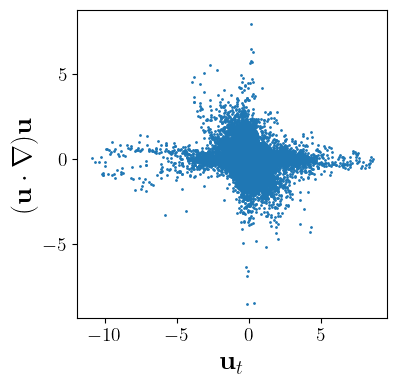

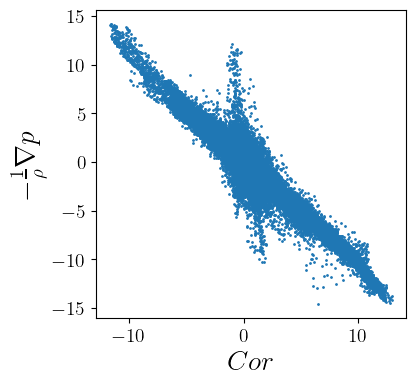

In [842]:
plt.figure(figsize=(4, 4))

# Plot the features
plt.scatter(features[:, 0], features[:, 1], s=1)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(features[:, 2], features[:, 3], s=1)
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.show()

## 3. Gaussian Mixture Model Clustering

In [843]:
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.5
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

n_clusters = 6
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

GaussianMixture(n_components=6, random_state=75016)

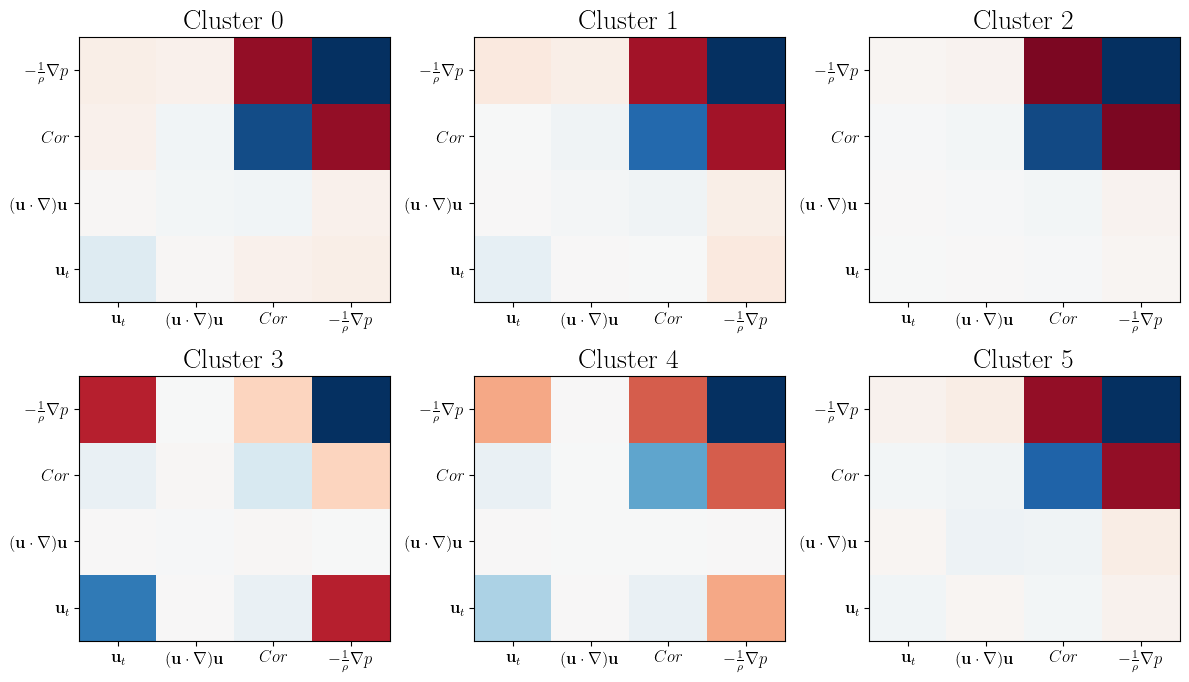

In [844]:
pf.plot_cov_mat(model, nfeatures, n_clusters, labels, "GMM")

In [845]:
# Predict clusters for a single snapshot
cluster_idx = model.predict(features)
cluster_idx.shape

(267806,)

In [846]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import os

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)

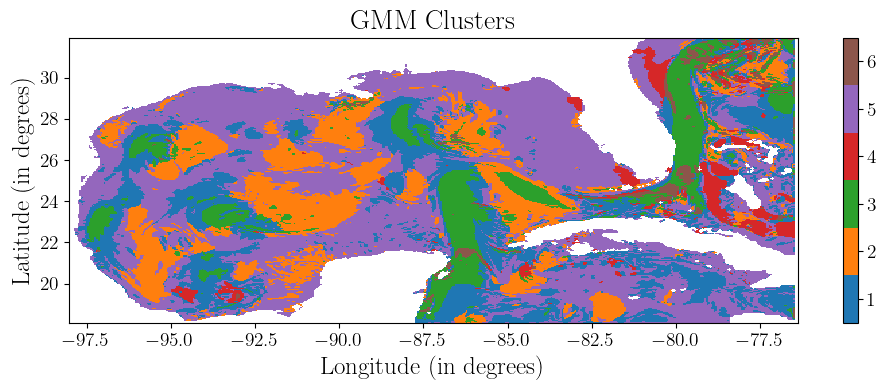

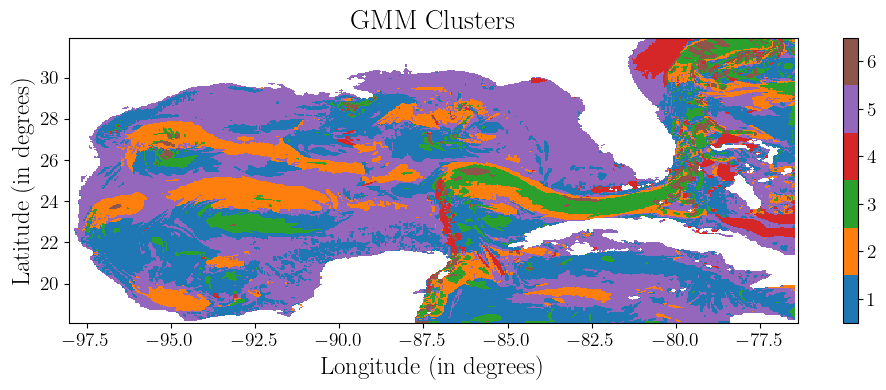

In [847]:
# Get the meridional and zonal points back
n_meridional = len(features_mer[:, 0])

cluster_idx_mer = np.zeros(len(u[0, :, :].flatten()), dtype=int) - 1
cluster_idx_zon = np.zeros(len(u[0, :, :].flatten()), dtype=int) - 1

cluster_idx_mer[~mer_nan] = cluster_idx[:n_meridional]
cluster_idx_zon[~zon_nan] = cluster_idx[n_meridional:]

clustermap_mer = cluster_idx_mer.reshape(ny, nx)
clustermap_zon = cluster_idx_zon.reshape(ny, nx)


# Plot the clusters in space
def plot_clustering_space_geo(clustermap, x, y, num_x, num_y, n_clusters, show=True):
    plt.figure(figsize=(10, 4))
    # Plot the clustering in space
    plt.pcolor(x, y, clustermap + 1, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5)
    plt.colorbar(
        boundaries=np.arange(0.5, n_clusters + 1.5), ticks=np.arange(0, n_clusters + 1)
    )

    plt.xlabel("Longitude (in degrees)", fontsize=18)
    plt.ylabel("Latitude (in degrees)", fontsize=18)
    plt.title("GMM Clusters", fontsize=20)

    plt.tight_layout()

    cur_dir = os.getcwd()
    proj_dir = os.path.dirname(cur_dir)
    plots_dir = os.path.join(proj_dir, "Plots")
    os.makedirs(plots_dir, exist_ok=True)

    plot_dir = os.path.join(plots_dir, "clustering_space_geo.png")
    plt.savefig(plot_dir)

    if show:
        plt.show()
    else:
        plt.close()


plot_clustering_space_geo(clustermap_mer, lon, lat, nx, ny, n_clusters)
plot_clustering_space_geo(clustermap_zon, lon, lat, nx, ny, n_clusters)

## 3.  SPCA identification of active terms